# Modello U-net base
In questo notebook è riportata la U-net che abbiamo nominato "base" utilizzata per il task di segmentazione ed è costituita da 4 blocchi per l'encoder e 4 blocchi per il decoder. Ogni blocco ha stack = 2 ed è costituito dalla sequenza di layers: Convoluzione, Batch Normalization e Attivazione. Infine un ultimo blocco viene richiamato nel bottleneck.


**Connect Colab to Google Drive**

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

%cd /gdrive/My Drive/U-net

Mounted at /gdrive
/gdrive/My Drive/U-net


**Import Libraries**

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
seed = 42

**Load the Data**

In [ ]:
data = np.load("mars_for_students_processed.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Check valori dei pixel
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

Min value: 2.0
Max value: 254.0


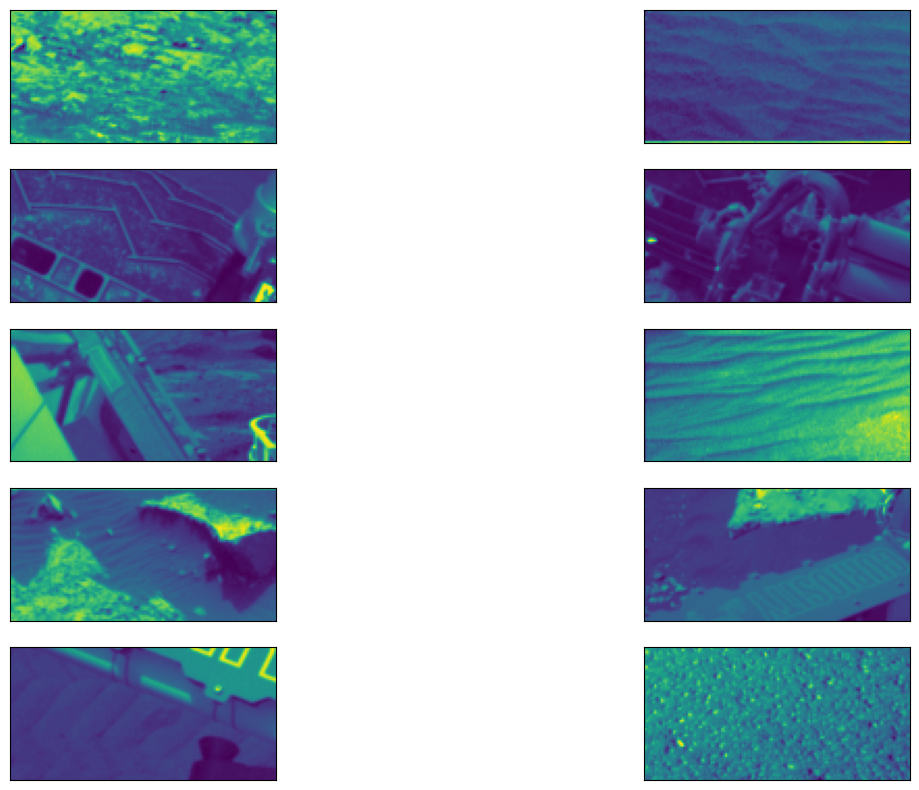

In [ ]:
# Campioni da X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

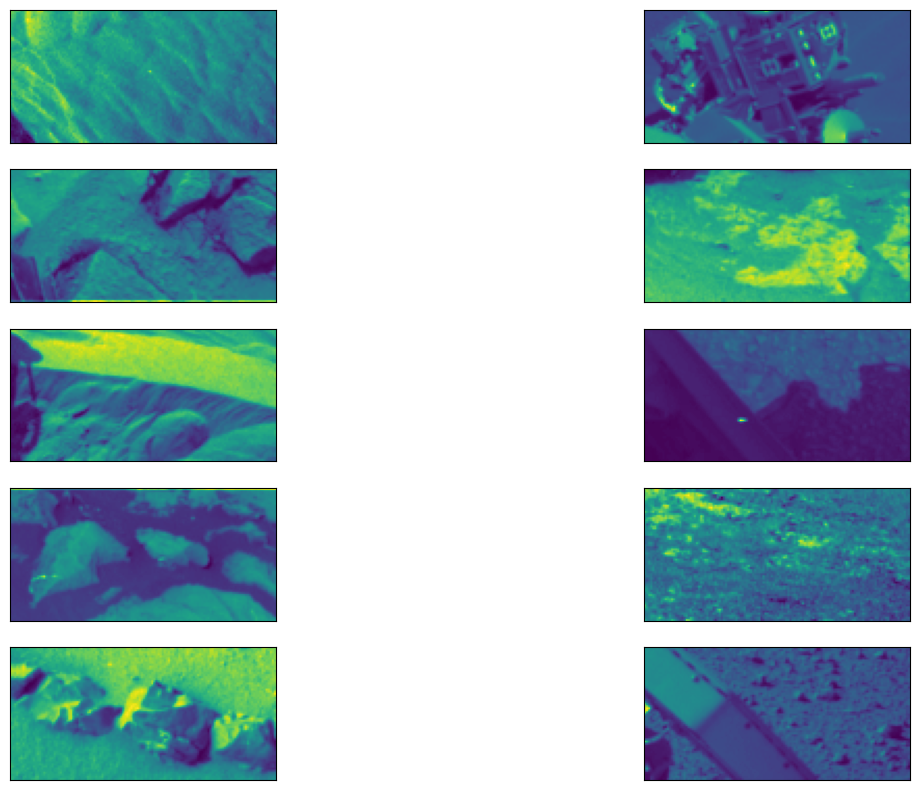

In [ ]:
# Campioni da X_test
plt.figure(figsize=(15,10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i+2000])
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

class_colors = {
    0: "black",     # Background
    1: "brown",     # Soil
    2: "gray",      # Bedrock
    3: "yellow",    # Sand
    4: "darkgreen"  # Big Rock
}
cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])

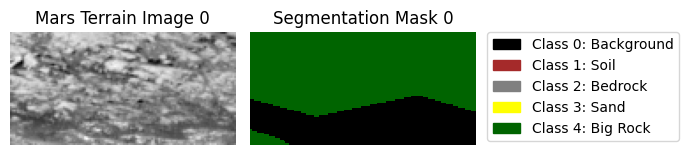

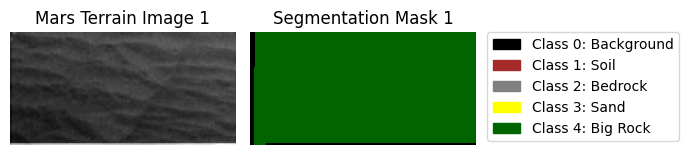

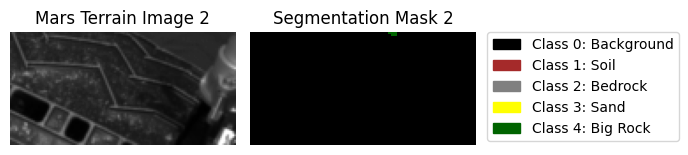

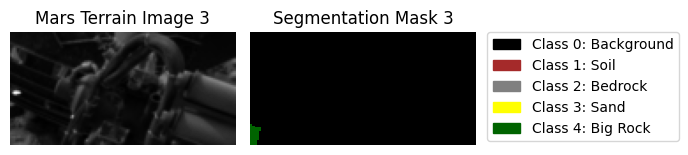

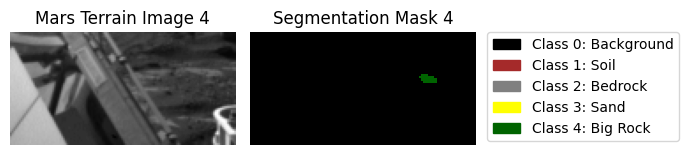

In [ ]:
# Legenda
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=class_colors[i], label=f"Class {i}: {label}")
                  for i, label in enumerate(["Background", "Soil", "Bedrock", "Sand", "Big Rock"])]

def display_images_with_masks(X_train, y_train, start, end):
    for i in range(start, end):
        image = X_train[i]
        mask = y_train[i]

        # Plot immagini e maschere
        plt.figure(figsize=(7, 5))

        # Immagini
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Mars Terrain Image {i}")
        plt.axis("off")

        # Maschere
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap=cmap, interpolation="none")
        plt.title(f"Segmentation Mask {i}")
        plt.axis("off")

        # Legenda
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()

display_images_with_masks(X_train, y_train, start=0, end=5)

## Creazione del dataset

**Parametri**

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
PATIENCE = 30
EPOCHS = 1000
SPLITS_SIZE = 300

**Costruttori dataset**

In [ ]:
# COSTRUTTORE TRAINING SET

def make_dataset(X_in, y_in, batch_size, shuffle=True, augment=False, seed=None):

    dataset = tf.data.Dataset.from_tensor_slices((X_in, y_in))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocessing
    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# COSTRUTTORE TEST SET

def make_test_dataset(X_test, batch_size, shuffle=False, seed=None):

    dataset = tf.data.Dataset.from_tensor_slices(X_test)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocessing
    dataset = dataset.map(
        lambda x: tf.cast(x, tf.float32) / 255.0,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

**Split train-validation**

In [ ]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Split train and val set
from sklearn.model_selection import train_test_split

train_img, val_img, train_lbl, val_lbl = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Print shape
print(f"Train images shape: {train_img.shape}")
print(f"Train labels shape: {train_lbl.shape}")
print(f"Validation images shape: {val_img.shape}")
print(f"Validation labels shape: {val_lbl.shape}")

Train images shape: (2004, 64, 128, 1)
Train labels shape: (2004, 64, 128)
Validation images shape: (501, 64, 128, 1)
Validation labels shape: (501, 64, 128)


**Creazione dei set**

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_dataset = make_test_dataset(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


## Definizione del modello U-net

**Blocco di layers**

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2):
    x = input_tensor

    for i in range(stack): # ciclo for - sequenza di layers che viene ripetuta
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    return x

**Osservazione:** parametri salienti scelti per il blocco sono kernel = 2 e stack = 2. Inoltre nella struttura sotto stante vengono settati i filtri da 64 (nel primo blocco e nell'ultimo) a 1024 (blocco richiamato nel bottleneck).

**U-net**

In [ ]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 1024, name='bottleneck')

    # Upsampling
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = unet_block(u1, 512, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 256, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 128, name='up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model()

# Summary
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 64)  │          256 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 64)  │       36,928 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 64)  │          256 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 64)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_4        │ (None, 32, 64, 64)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d_4[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 128)  │          512 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 128)  │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 128)  │      147,584 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 128)  │          512 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 31,401,605 (119.79 MB)

 Trainable params: 31,389,829 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name='mean_iou')

model.compile(optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", mean_iou])

**Callbacks**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode = 'max',
    factor=0.1,
    patience=10,
    min_delta=1e-5
)

In [ ]:
def apply_colormap(label, colormap=None):

    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = cmap

    # Normalize the label to fit colormap's range [0, 1]
    normalized_label = label.astype(float) / (np.max(label) if np.max(label) > 0 else 1)

    # Apply the colormap as a function
    colored = colormap(normalized_label)

    return colored

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5, num_classes=5):

        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Use a random index from the provided images
            idx = np.random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]

            # Expand image dims to simulate batch for model prediction
            image_batch = tf.expand_dims(image, 0)

            # Predict the segmentation mask
            pred = self.model.predict(image_batch, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Convert to NumPy

            # Visualization
            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, cmap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, cmap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

viz_callback = VizCallback(val_img, val_lbl, frequency=5, num_classes=5)

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3502 - loss: 1.4951 - mean_iou: 0.1603   

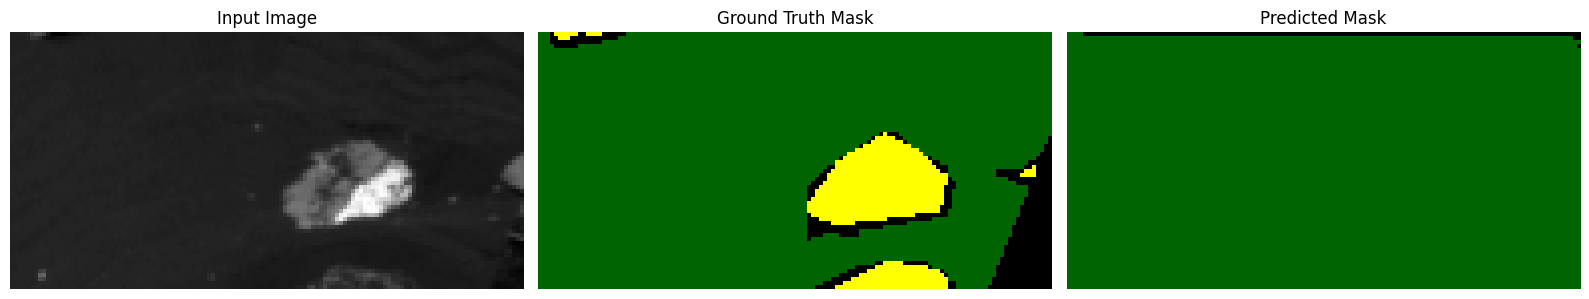

32/32 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.3524 - loss: 1.4898 - mean_iou: 0.1613 - val_accuracy: 0.0054 - val_loss: 2373.1062 - val_mean_iou: 3.7908e-04 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 538ms/step - accuracy: 0.5282 - loss: 1.1362 - mean_iou: 0.2547 - val_accuracy: 0.2408 - val_loss: 183.5016 - val_mean_iou: 0.0031 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - accuracy: 0.5813 - loss: 1.0340 - mean_iou: 0.2997 - val_accuracy: 0.0820 - val_loss: 21.9853 - val_mean_iou: 0.0366 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - accuracy: 0.5992 - loss: 0.9872 - mean_iou: 0.3141 - val_accuracy: 0.2164 - val_loss: 9.5423 - val_mean_iou: 0.0446 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - accuracy: 0.6329 - loss: 0.9383 - mean_iou: 0.3446 - val_accuracy: 0.1979 - val_loss: 13.3104 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 6/1000
32/32 

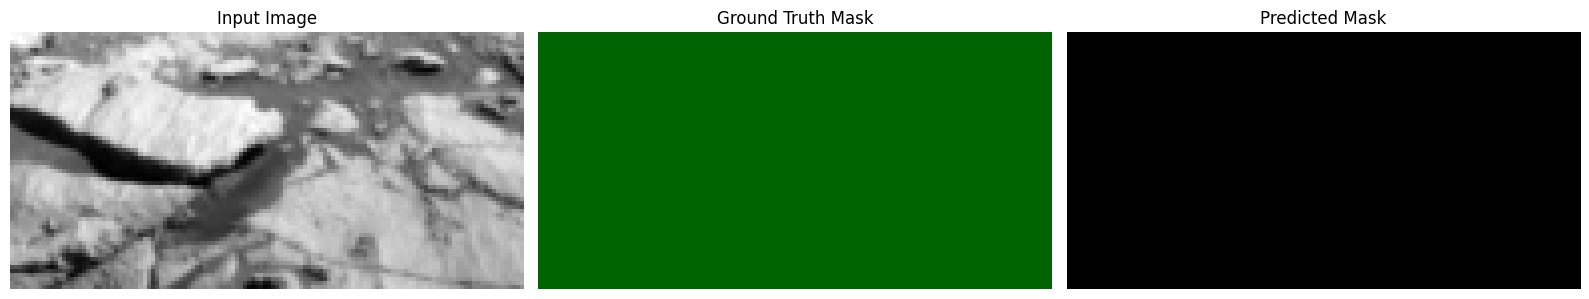

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 531ms/step - accuracy: 0.6463 - loss: 0.9065 - mean_iou: 0.3494 - val_accuracy: 0.2166 - val_loss: 4.7510 - val_mean_iou: 0.0423 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.6686 - loss: 0.8501 - mean_iou: 0.3730 - val_accuracy: 0.1979 - val_loss: 6.9097 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.6806 - loss: 0.8301 - mean_iou: 0.3863 - val_accuracy: 0.1980 - val_loss: 6.6055 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 0.6853 - loss: 0.8132 - mean_iou: 0.3913 - val_accuracy: 0.1979 - val_loss: 6.2332 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - accuracy: 0.7121 - loss: 0.7603 - mean_iou: 0.4270 - val_accuracy: 0.1982 - val_loss: 4.6631 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━

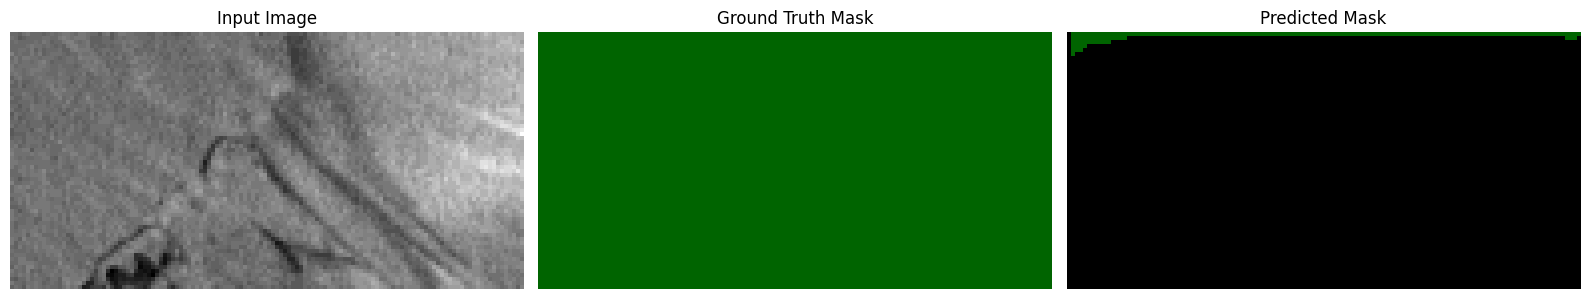

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step - accuracy: 0.7191 - loss: 0.7407 - mean_iou: 0.4221 - val_accuracy: 0.1980 - val_loss: 6.4388 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.7060 - loss: 0.7579 - mean_iou: 0.4097 - val_accuracy: 0.1988 - val_loss: 7.2096 - val_mean_iou: 0.0525 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 509ms/step - accuracy: 0.7263 - loss: 0.7146 - mean_iou: 0.4284 - val_accuracy: 0.2454 - val_loss: 3.7985 - val_mean_iou: 0.0824 - learning_rate: 0.0010
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.7292 - loss: 0.7071 - mean_iou: 0.4302 - val_accuracy: 0.2787 - val_loss: 4.2922 - val_mean_iou: 0.0786 - learning_rate: 0.0010
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - accuracy: 0.7153 - loss: 0.7440 - mean_iou: 0.4275 - val_accuracy: 0.2804 - val_loss: 4.4308 - val_mean_iou: 0.1050 - learning_rate: 0.0010
Epoch 16/1000
32/32 ━━━━

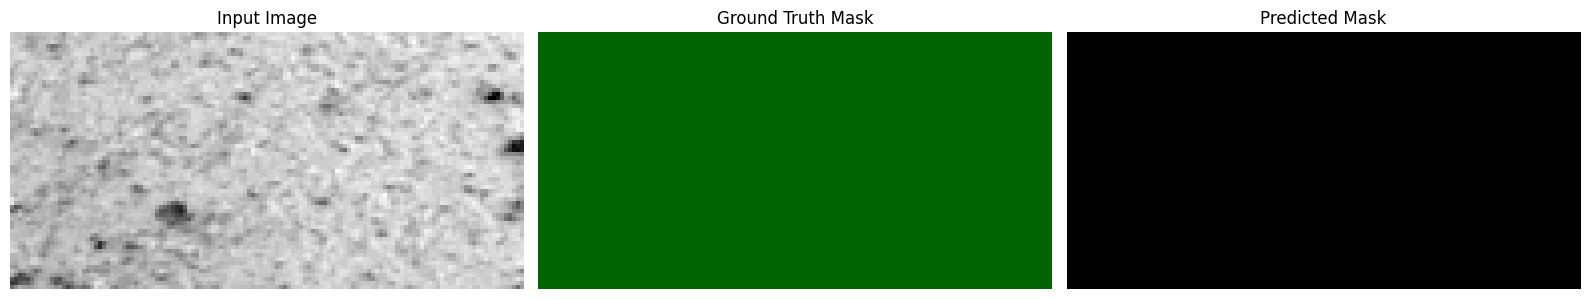

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 524ms/step - accuracy: 0.7411 - loss: 0.6822 - mean_iou: 0.4472 - val_accuracy: 0.3670 - val_loss: 2.4895 - val_mean_iou: 0.1564 - learning_rate: 0.0010
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 515ms/step - accuracy: 0.7434 - loss: 0.6679 - mean_iou: 0.4469 - val_accuracy: 0.4100 - val_loss: 3.1137 - val_mean_iou: 0.2111 - learning_rate: 0.0010
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 547ms/step - accuracy: 0.7577 - loss: 0.6416 - mean_iou: 0.4624 - val_accuracy: 0.5411 - val_loss: 1.4260 - val_mean_iou: 0.2595 - learning_rate: 0.0010
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.7517 - loss: 0.6508 - mean_iou: 0.4526 - val_accuracy: 0.6516 - val_loss: 0.9737 - val_mean_iou: 0.3662 - learning_rate: 0.0010
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step - accuracy: 0.7557 - loss: 0.6431 - mean_iou: 0.4583 - val_accuracy: 0.5373 - val_loss: 1.5524 - val_mean_iou: 0.2810 - learning_rate: 0.0010
Epoch 21/1000
32/32 ━━━━

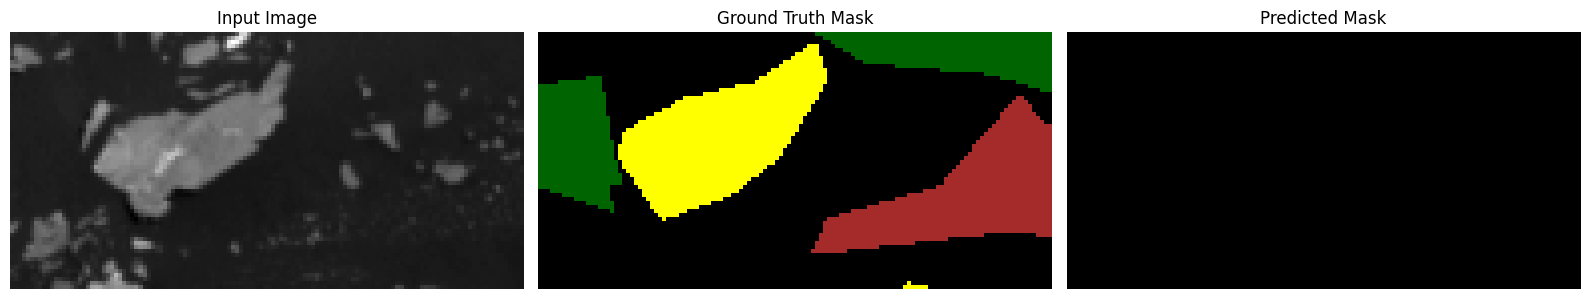

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - accuracy: 0.7590 - loss: 0.6258 - mean_iou: 0.4660 - val_accuracy: 0.5013 - val_loss: 2.0918 - val_mean_iou: 0.2246 - learning_rate: 0.0010
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.7766 - loss: 0.5913 - mean_iou: 0.4857 - val_accuracy: 0.6311 - val_loss: 1.5188 - val_mean_iou: 0.3289 - learning_rate: 0.0010
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step - accuracy: 0.7836 - loss: 0.5727 - mean_iou: 0.4866 - val_accuracy: 0.6330 - val_loss: 0.9925 - val_mean_iou: 0.3560 - learning_rate: 0.0010
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.7717 - loss: 0.5945 - mean_iou: 0.4756 - val_accuracy: 0.6208 - val_loss: 1.0447 - val_mean_iou: 0.2922 - learning_rate: 0.0010
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 505ms/step - accuracy: 0.7754 - loss: 0.5857 - mean_iou: 0.4694 - val_accuracy: 0.5892 - val_loss: 1.8112 - val_mean_iou: 0.3177 - learning_rate: 0.0010
Epoch 26/1000
32/32 ━━━━

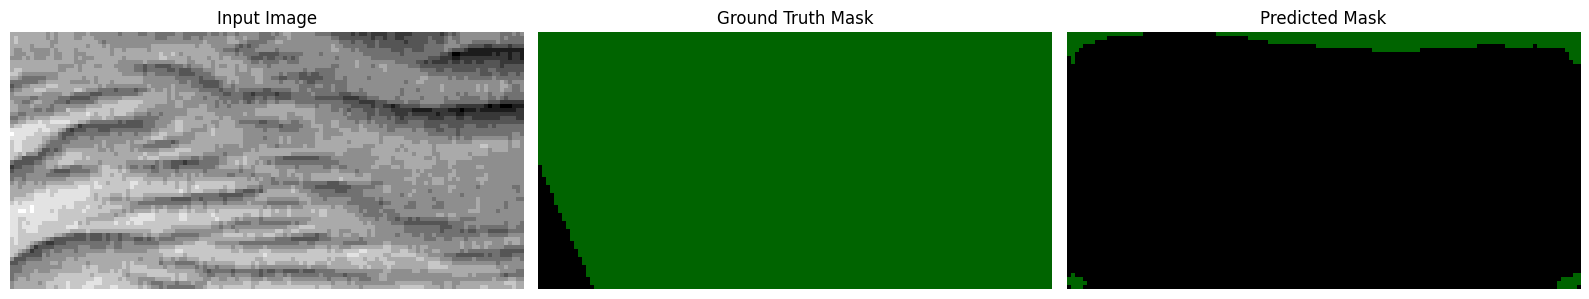

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 532ms/step - accuracy: 0.7692 - loss: 0.5929 - mean_iou: 0.4635 - val_accuracy: 0.5501 - val_loss: 1.9640 - val_mean_iou: 0.2500 - learning_rate: 0.0010
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 548ms/step - accuracy: 0.7789 - loss: 0.5784 - mean_iou: 0.4796 - val_accuracy: 0.6846 - val_loss: 1.0108 - val_mean_iou: 0.3894 - learning_rate: 0.0010
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.7841 - loss: 0.5698 - mean_iou: 0.4887 - val_accuracy: 0.6173 - val_loss: 1.5674 - val_mean_iou: 0.2812 - learning_rate: 0.0010
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - accuracy: 0.7963 - loss: 0.5376 - mean_iou: 0.4905 - val_accuracy: 0.6309 - val_loss: 1.1208 - val_mean_iou: 0.2923 - learning_rate: 0.0010
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 551ms/step - accuracy: 0.8021 - loss: 0.5195 - mean_iou: 0.4981 - val_accuracy: 0.6538 - val_loss: 1.2147 - val_mean_iou: 0.3379 - learning_rate: 0.0010
Epoch 31/1000
32/32 ━━━━

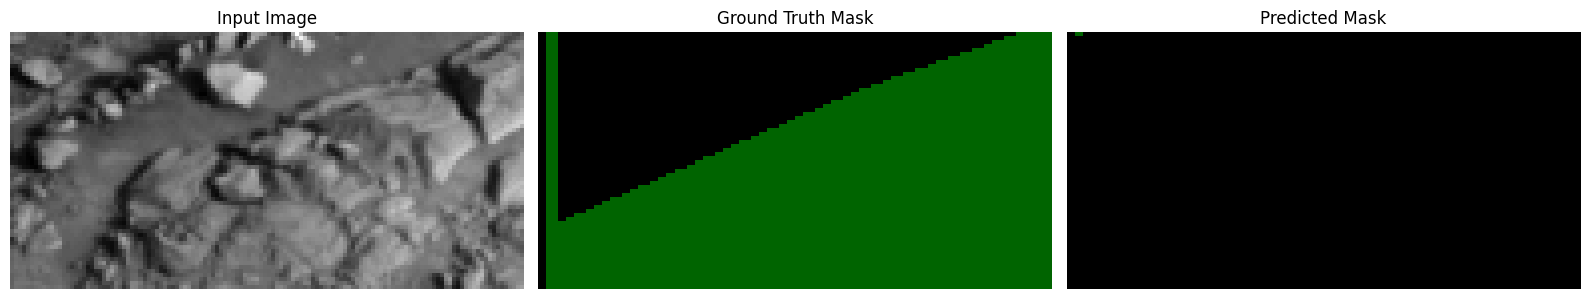

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.8060 - loss: 0.5176 - mean_iou: 0.5048 - val_accuracy: 0.6316 - val_loss: 1.1163 - val_mean_iou: 0.3005 - learning_rate: 0.0010
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.8203 - loss: 0.4829 - mean_iou: 0.5025 - val_accuracy: 0.6914 - val_loss: 0.9184 - val_mean_iou: 0.3652 - learning_rate: 0.0010
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 510ms/step - accuracy: 0.8116 - loss: 0.5028 - mean_iou: 0.4990 - val_accuracy: 0.6488 - val_loss: 1.0851 - val_mean_iou: 0.3298 - learning_rate: 0.0010
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.8297 - loss: 0.4625 - mean_iou: 0.5140 - val_accuracy: 0.6208 - val_loss: 1.0424 - val_mean_iou: 0.3188 - learning_rate: 0.0010
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.8268 - loss: 0.4591 - mean_iou: 0.5116 - val_accuracy: 0.4887 - val_loss: 1.6497 - val_mean_iou: 0.1853 - learning_rate: 0.0010
Epoch 36/1000
32/32 ━━━━

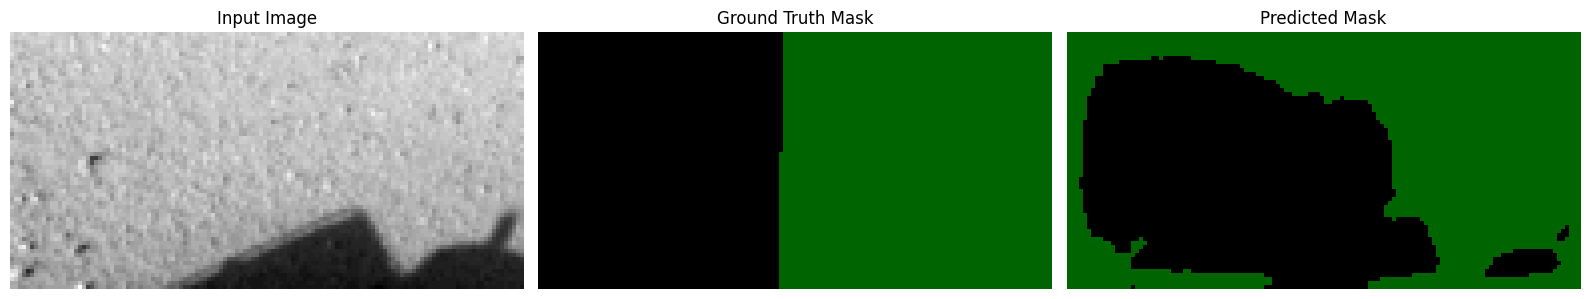

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - accuracy: 0.8323 - loss: 0.4473 - mean_iou: 0.5132 - val_accuracy: 0.6261 - val_loss: 1.6395 - val_mean_iou: 0.3238 - learning_rate: 0.0010
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 509ms/step - accuracy: 0.8350 - loss: 0.4366 - mean_iou: 0.5227 - val_accuracy: 0.4439 - val_loss: 2.1770 - val_mean_iou: 0.1591 - learning_rate: 0.0010
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step - accuracy: 0.8585 - loss: 0.3817 - mean_iou: 0.5416 - val_accuracy: 0.6036 - val_loss: 1.4200 - val_mean_iou: 0.2812 - learning_rate: 1.0000e-04
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.8700 - loss: 0.3494 - mean_iou: 0.5433 - val_accuracy: 0.7074 - val_loss: 0.9541 - val_mean_iou: 0.3838 - learning_rate: 1.0000e-04
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 512ms/step - accuracy: 0.8723 - loss: 0.3391 - mean_iou: 0.5472 - val_accuracy: 0.7415 - val_loss: 0.7806 - val_mean_iou: 0.4249 - learning_rate: 1.0000e-04
Epoch 41/100

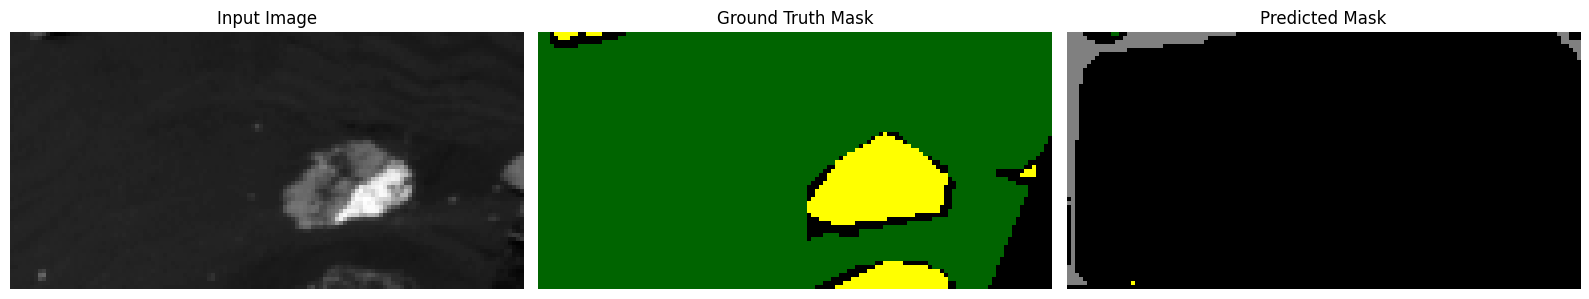

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - accuracy: 0.8752 - loss: 0.3300 - mean_iou: 0.5502 - val_accuracy: 0.7649 - val_loss: 0.6676 - val_mean_iou: 0.4560 - learning_rate: 1.0000e-04
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 516ms/step - accuracy: 0.8800 - loss: 0.3190 - mean_iou: 0.5500 - val_accuracy: 0.7671 - val_loss: 0.6650 - val_mean_iou: 0.4630 - learning_rate: 1.0000e-04
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 511ms/step - accuracy: 0.8889 - loss: 0.2951 - mean_iou: 0.5574 - val_accuracy: 0.7705 - val_loss: 0.6485 - val_mean_iou: 0.4664 - learning_rate: 1.0000e-04
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 542ms/step - accuracy: 0.8873 - loss: 0.3046 - mean_iou: 0.5556 - val_accuracy: 0.7668 - val_loss: 0.6581 - val_mean_iou: 0.4624 - learning_rate: 1.0000e-04
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 508ms/step - accuracy: 0.8905 - loss: 0.2894 - mean_iou: 0.5587 - val_accuracy: 0.7746 - val_loss: 0.6481 - val_mean_iou: 0.4752 - learning_rate: 1.0000e-04
Epoc

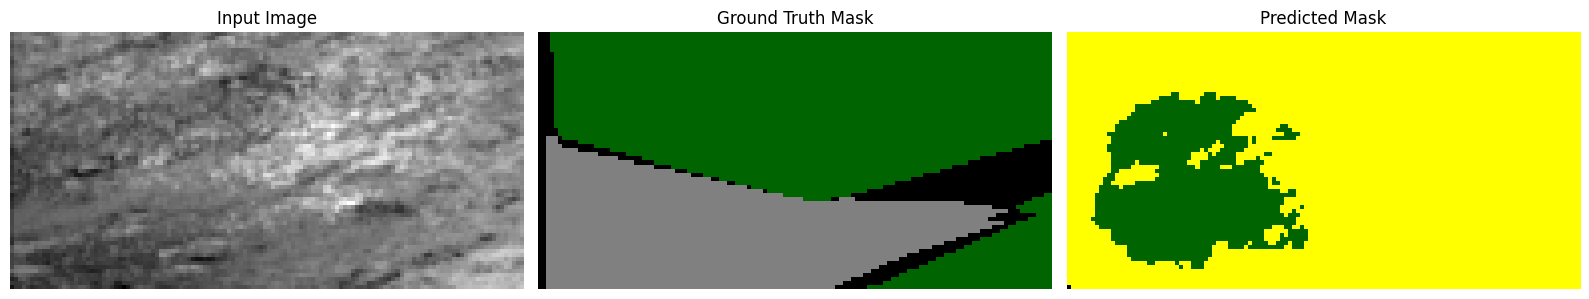

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 551ms/step - accuracy: 0.8975 - loss: 0.2744 - mean_iou: 0.5549 - val_accuracy: 0.7696 - val_loss: 0.6787 - val_mean_iou: 0.4666 - learning_rate: 1.0000e-04
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 555ms/step - accuracy: 0.8985 - loss: 0.2745 - mean_iou: 0.5572 - val_accuracy: 0.7762 - val_loss: 0.6619 - val_mean_iou: 0.4768 - learning_rate: 1.0000e-04
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.8978 - loss: 0.2768 - mean_iou: 0.5571 - val_accuracy: 0.7723 - val_loss: 0.6878 - val_mean_iou: 0.4713 - learning_rate: 1.0000e-04
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 544ms/step - accuracy: 0.9014 - loss: 0.2638 - mean_iou: 0.5574 - val_accuracy: 0.7715 - val_loss: 0.6842 - val_mean_iou: 0.4661 - learning_rate: 1.0000e-04
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - accuracy: 0.9053 - loss: 0.2603 - mean_iou: 0.5640 - val_accuracy: 0.7693 - val_loss: 0.7047 - val_mean_iou: 0.4691 - learning_rate: 1.0000e-04
Epoc

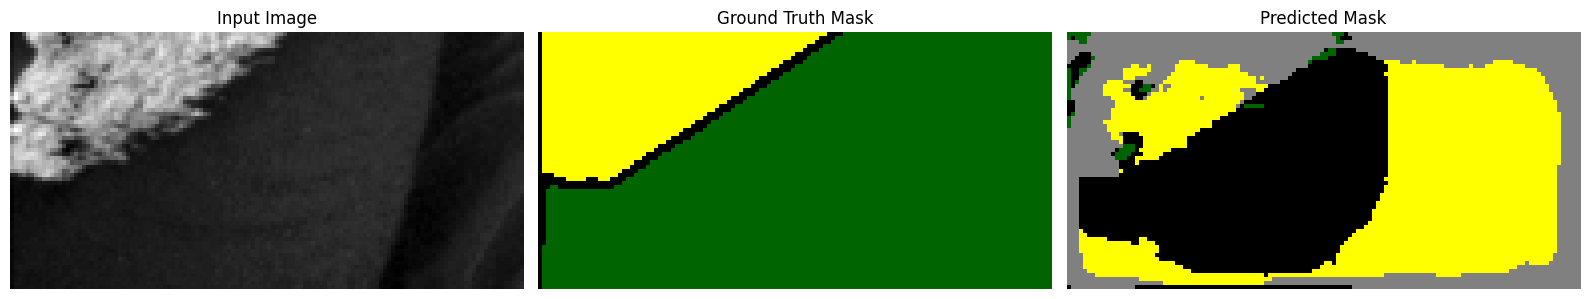

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.9114 - loss: 0.2436 - mean_iou: 0.5656 - val_accuracy: 0.7664 - val_loss: 0.7071 - val_mean_iou: 0.4666 - learning_rate: 1.0000e-04
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.9119 - loss: 0.2423 - mean_iou: 0.5647 - val_accuracy: 0.7723 - val_loss: 0.6981 - val_mean_iou: 0.4694 - learning_rate: 1.0000e-04
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.9115 - loss: 0.2450 - mean_iou: 0.5592 - val_accuracy: 0.7767 - val_loss: 0.6976 - val_mean_iou: 0.4787 - learning_rate: 1.0000e-04
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 543ms/step - accuracy: 0.9168 - loss: 0.2283 - mean_iou: 0.5681 - val_accuracy: 0.7609 - val_loss: 0.7389 - val_mean_iou: 0.4621 - learning_rate: 1.0000e-04
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step - accuracy: 0.9176 - loss: 0.2296 - mean_iou: 0.5674 - val_accuracy: 0.7700 - val_loss: 0.7175 - val_mean_iou: 0.4720 - learning_rate: 1.0000e-04
Epoc

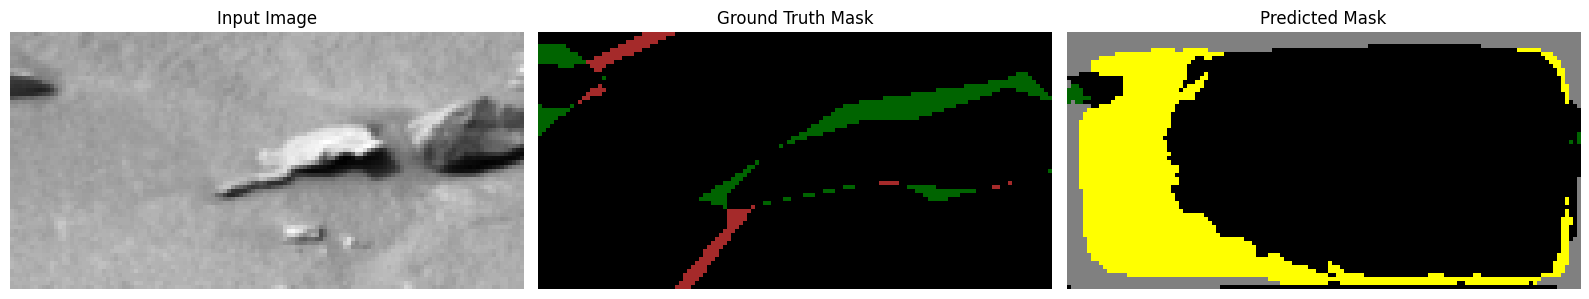

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 553ms/step - accuracy: 0.9217 - loss: 0.2171 - mean_iou: 0.5711 - val_accuracy: 0.7670 - val_loss: 0.7239 - val_mean_iou: 0.4698 - learning_rate: 1.0000e-04
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 515ms/step - accuracy: 0.9248 - loss: 0.2065 - mean_iou: 0.5744 - val_accuracy: 0.7627 - val_loss: 0.7385 - val_mean_iou: 0.4656 - learning_rate: 1.0000e-04
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.9219 - loss: 0.2150 - mean_iou: 0.5733 - val_accuracy: 0.7680 - val_loss: 0.7475 - val_mean_iou: 0.4595 - learning_rate: 1.0000e-04
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 545ms/step - accuracy: 0.9194 - loss: 0.2250 - mean_iou: 0.5658 - val_accuracy: 0.7691 - val_loss: 0.7219 - val_mean_iou: 0.4637 - learning_rate: 1.0000e-04
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 550ms/step - accuracy: 0.9254 - loss: 0.2075 - mean_iou: 0.5727 - val_accuracy: 0.7729 - val_loss: 0.7179 - val_mean_iou: 0.4748 - learning_rate: 1.0000e-04
Epoc

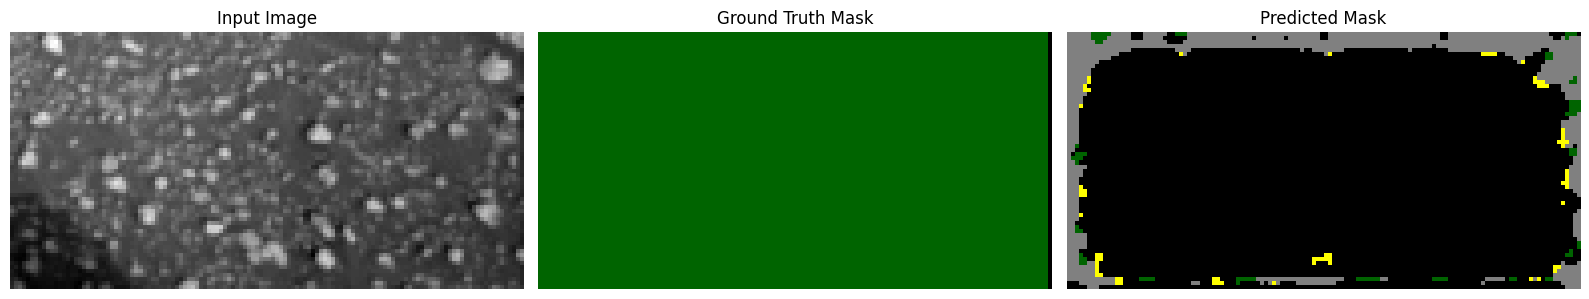

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.9269 - loss: 0.2041 - mean_iou: 0.5727 - val_accuracy: 0.7718 - val_loss: 0.7353 - val_mean_iou: 0.4769 - learning_rate: 1.0000e-04
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.9233 - loss: 0.2127 - mean_iou: 0.5670 - val_accuracy: 0.7735 - val_loss: 0.7252 - val_mean_iou: 0.4733 - learning_rate: 1.0000e-04
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 514ms/step - accuracy: 0.9288 - loss: 0.1980 - mean_iou: 0.5750 - val_accuracy: 0.7733 - val_loss: 0.7517 - val_mean_iou: 0.4743 - learning_rate: 1.0000e-04
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - accuracy: 0.9332 - loss: 0.1856 - mean_iou: 0.5824 - val_accuracy: 0.7695 - val_loss: 0.7284 - val_mean_iou: 0.4738 - learning_rate: 1.0000e-05
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.9328 - loss: 0.1861 - mean_iou: 0.5735 - val_accuracy: 0.7661 - val_loss: 0.7303 - val_mean_iou: 0.4697 - learning_rate: 1.0000e-05
Epoc

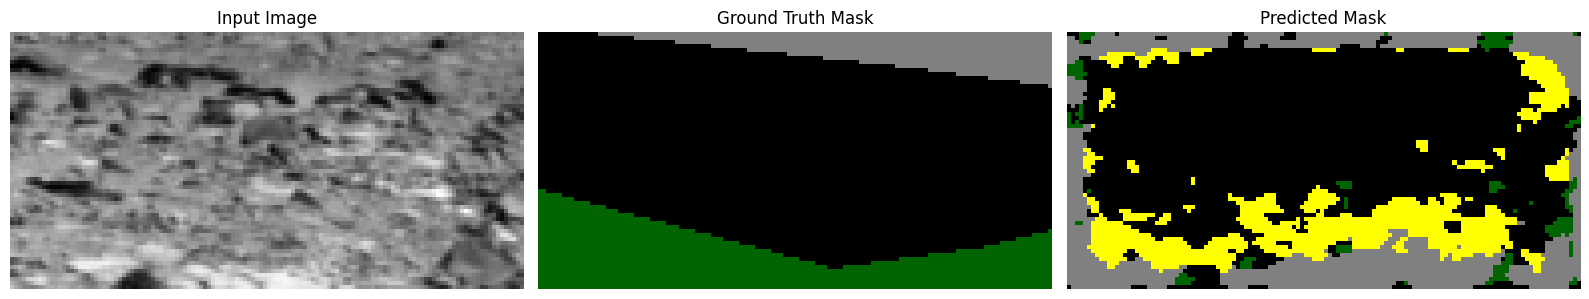

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.9367 - loss: 0.1791 - mean_iou: 0.5788 - val_accuracy: 0.7641 - val_loss: 0.7341 - val_mean_iou: 0.4658 - learning_rate: 1.0000e-05
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.9314 - loss: 0.1924 - mean_iou: 0.5711 - val_accuracy: 0.7627 - val_loss: 0.7419 - val_mean_iou: 0.4655 - learning_rate: 1.0000e-05
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 0.9392 - loss: 0.1736 - mean_iou: 0.5808 - val_accuracy: 0.7631 - val_loss: 0.7425 - val_mean_iou: 0.4638 - learning_rate: 1.0000e-05
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.9351 - loss: 0.1820 - mean_iou: 0.5735 - val_accuracy: 0.7624 - val_loss: 0.7432 - val_mean_iou: 0.4639 - learning_rate: 1.0000e-05
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.9382 - loss: 0.1741 - mean_iou: 0.5756 - val_accuracy: 0.7625 - val_loss: 0.7489 - val_mean_iou: 0.4632 - learning_rate: 1.0000e-05
Epoc

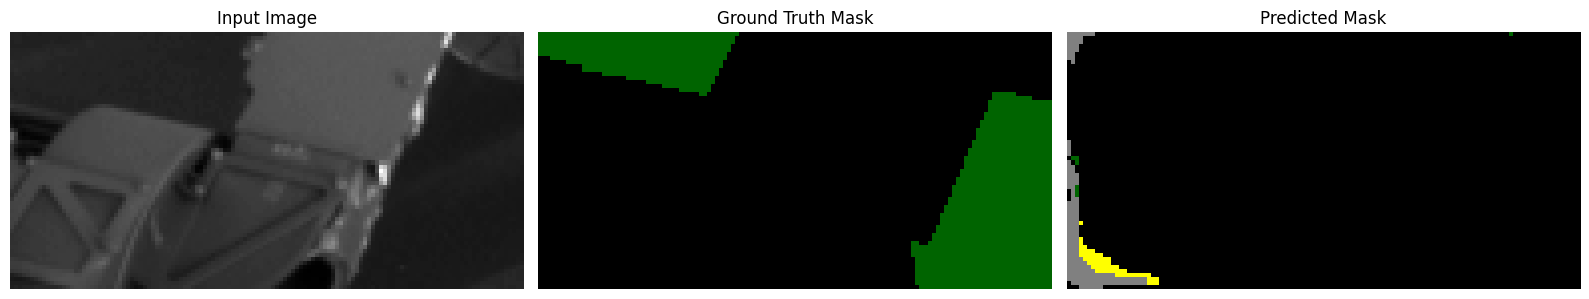

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.9361 - loss: 0.1822 - mean_iou: 0.5729 - val_accuracy: 0.7622 - val_loss: 0.7517 - val_mean_iou: 0.4642 - learning_rate: 1.0000e-05
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 549ms/step - accuracy: 0.9395 - loss: 0.1723 - mean_iou: 0.5764 - val_accuracy: 0.7632 - val_loss: 0.7535 - val_mean_iou: 0.4647 - learning_rate: 1.0000e-05
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.9384 - loss: 0.1739 - mean_iou: 0.5755 - val_accuracy: 0.7631 - val_loss: 0.7595 - val_mean_iou: 0.4641 - learning_rate: 1.0000e-05
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.9391 - loss: 0.1717 - mean_iou: 0.5821 - val_accuracy: 0.7623 - val_loss: 0.7620 - val_mean_iou: 0.4631 - learning_rate: 1.0000e-06
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 546ms/step - accuracy: 0.9359 - loss: 0.1801 - mean_iou: 0.5804 - val_accuracy: 0.7612 - val_loss: 0.7648 - val_mean_iou: 0.4619 - learning_rate: 1.0000e-06
Epoc

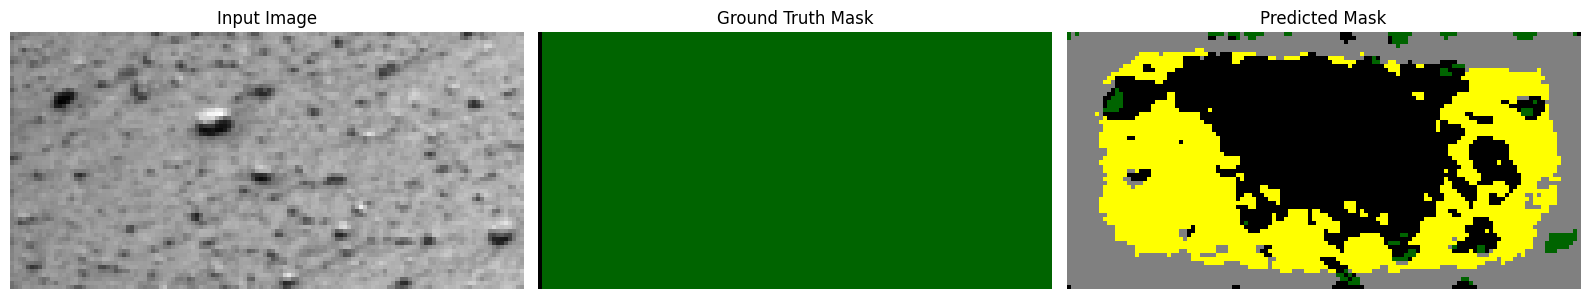

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 524ms/step - accuracy: 0.9370 - loss: 0.1775 - mean_iou: 0.5797 - val_accuracy: 0.7605 - val_loss: 0.7666 - val_mean_iou: 0.4609 - learning_rate: 1.0000e-06
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.9383 - loss: 0.1736 - mean_iou: 0.5770 - val_accuracy: 0.7601 - val_loss: 0.7669 - val_mean_iou: 0.4604 - learning_rate: 1.0000e-06
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 510ms/step - accuracy: 0.9359 - loss: 0.1789 - mean_iou: 0.5793 - val_accuracy: 0.7601 - val_loss: 0.7682 - val_mean_iou: 0.4600 - learning_rate: 1.0000e-06
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 543ms/step - accuracy: 0.9391 - loss: 0.1725 - mean_iou: 0.5801 - val_accuracy: 0.7601 - val_loss: 0.7694 - val_mean_iou: 0.4598 - learning_rate: 1.0000e-06
Epoch 80/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.9385 - loss: 0.1731 - mean_iou: 0.5787 - val_accuracy: 0.7601 - val_loss: 0.7700 - val_mean_iou: 0.4597 - learning_rate: 1.0000e-06
Epoc

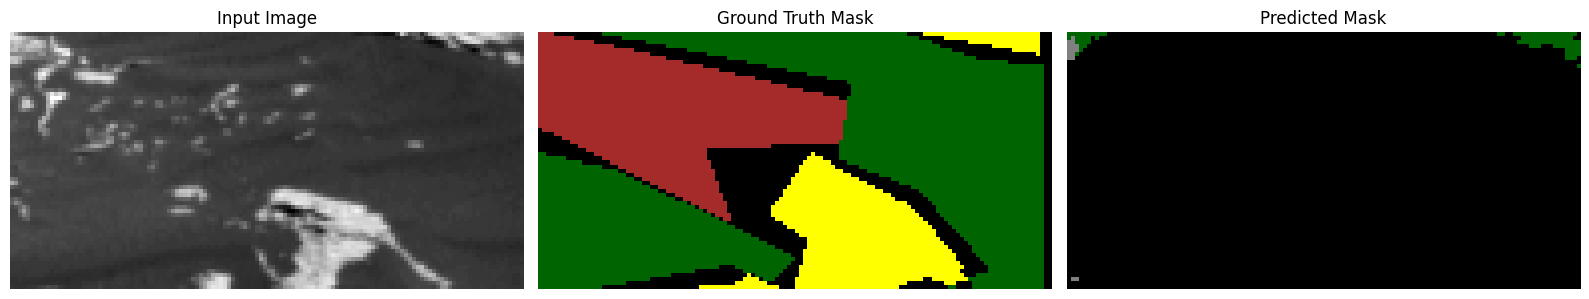

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 524ms/step - accuracy: 0.9410 - loss: 0.1667 - mean_iou: 0.5818 - val_accuracy: 0.7597 - val_loss: 0.7706 - val_mean_iou: 0.4591 - learning_rate: 1.0000e-06
Epoch 82/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - accuracy: 0.9347 - loss: 0.1804 - mean_iou: 0.5778 - val_accuracy: 0.7593 - val_loss: 0.7718 - val_mean_iou: 0.4586 - learning_rate: 1.0000e-06
Epoch 83/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 507ms/step - accuracy: 0.9383 - loss: 0.1753 - mean_iou: 0.5797 - val_accuracy: 0.7593 - val_loss: 0.7704 - val_mean_iou: 0.4592 - learning_rate: 1.0000e-06
Final validation Mean Intersection Over Union: 47.87%


In [ ]:
# Training del modello
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_plateau, viz_callback],
    verbose=1
).history

final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

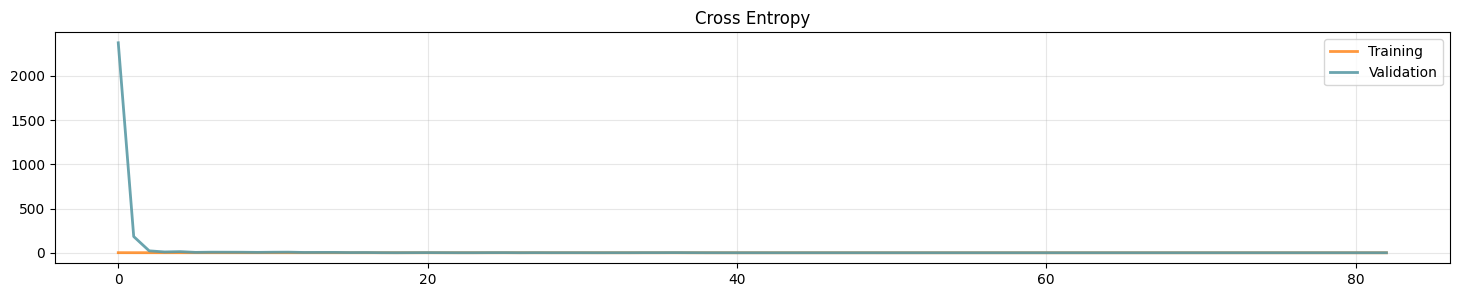

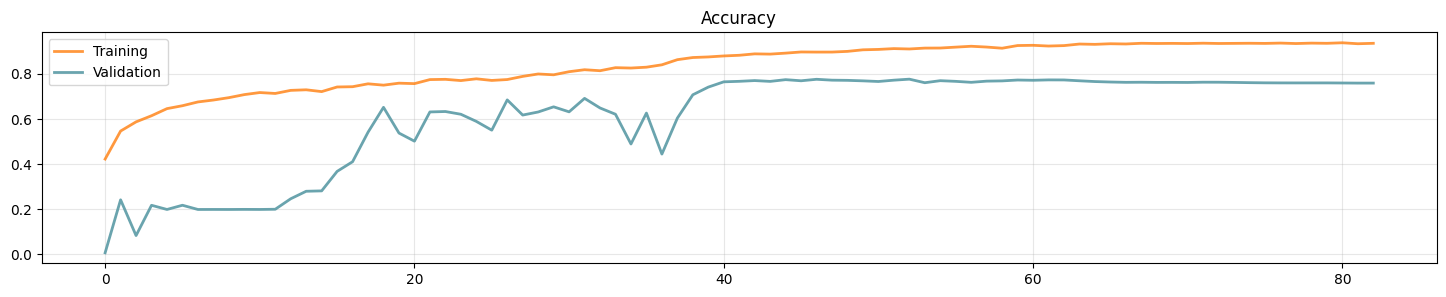

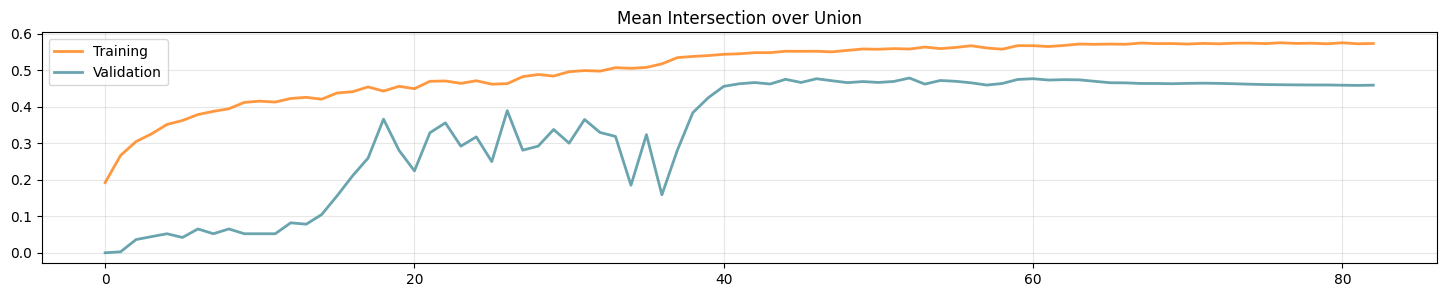

In [ ]:
# Plot training e validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot training e validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot training e validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Visualize prediction validation set

In [ ]:
y_val_pred = model.predict(val_dataset)
y_val_pred = np.argmax(y_val_pred, axis=-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step


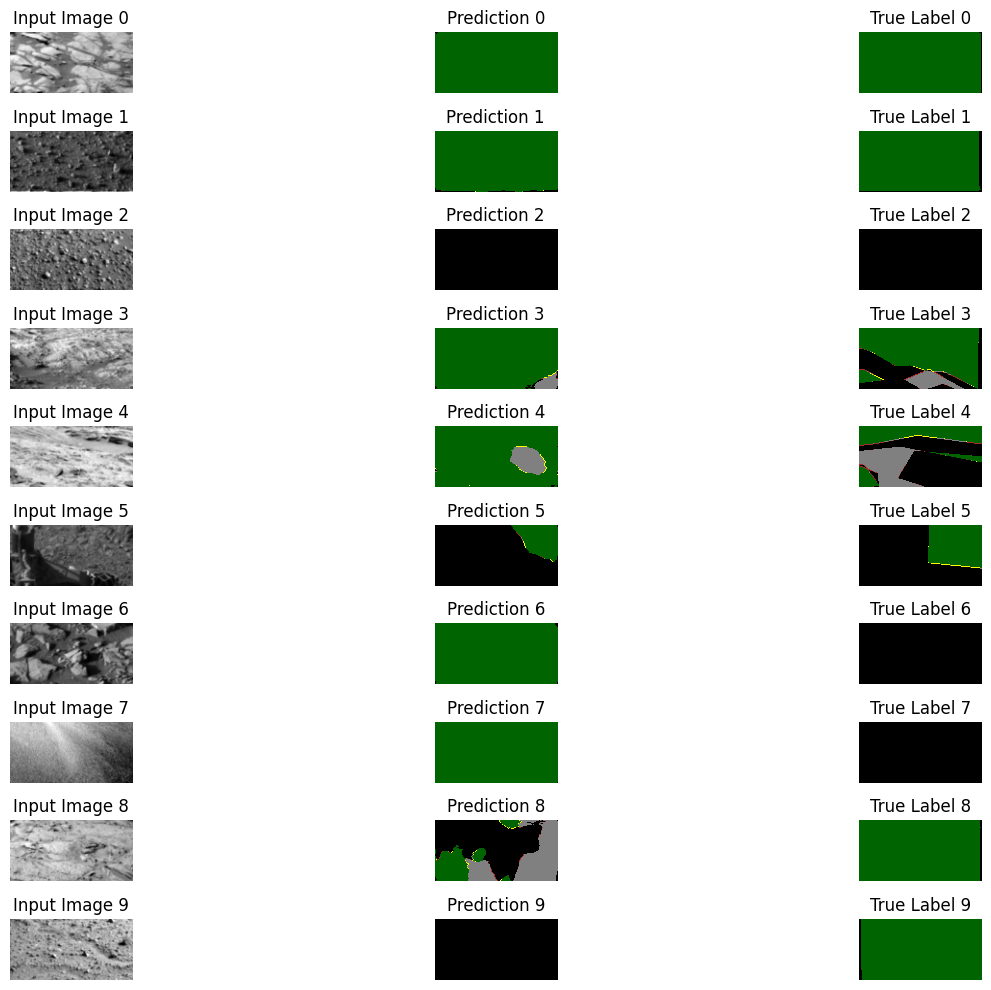

In [ ]:
def display_images_with_predictions_and_true_labels(input_images, predictions, true_labels, start=0, end=5, figsize=(15, 10)):
    """
    Display input images, model predictions, and true labels for visual comparison.

    Parameters:
    - input_images: Array of input images (e.g., grayscale terrain images).
    - predictions: Array of predicted segmentation masks (output from the model).
    - true_labels: Array of ground truth segmentation masks.
    - start: Index to start the display from.
    - end: Index to stop the display at (inclusive).
    - figsize: Size of the figure for plotting.
    """

    # Set up the figure for displaying images
    fig, axes = plt.subplots(end - start, 3, figsize=figsize)

    for i in range(start, end):
        # Display the input image
        axes[i-start, 0].imshow(input_images[i, :, :, 0], cmap='gray')
        axes[i-start, 0].set_title(f'Input Image {i}')
        axes[i-start, 0].axis('off')

        # Display the predicted mask
        axes[i-start, 1].imshow(predictions[i, :, :], cmap=cmap)  # Use a color map for prediction
        axes[i-start, 1].set_title(f'Prediction {i}')
        axes[i-start, 1].axis('off')

        # Display the true mask
        axes[i-start, 2].imshow(true_labels[i, :, :], cmap=cmap)  # Use the same color map for ground truth
        axes[i-start, 2].set_title(f'True Label {i}')
        axes[i-start, 2].axis('off')

    plt.tight_layout()
    plt.show()

display_images_with_predictions_and_true_labels(val_img, y_val_pred, val_lbl, start=0, end=10)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def compute_metrics(y_true, y_pred, num_classes=5):
    """
    Compute precision, recall, and accuracy for segmentation tasks.
    Parameters:
    - y_true: Ground truth labels (numpy array).
    - y_pred: Predicted labels (numpy array).
    - num_classes: Number of classes (including background).

    Returns:
    - precision: Per-class precision.
    - recall: Per-class recall.
    - accuracy: Overall accuracy.
    """
    # Flatten the arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Precision and Recall for each class
    precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))
    recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))

    # Overall Accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat)

    return precision, recall, accuracy

# Compute metrics
precision, recall, accuracy = compute_metrics(val_lbl, y_val_pred, num_classes=5)

# Print results
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"Overall Accuracy: {accuracy}")

Precision (per class): [0.73759922 0.80456405 0.7320446  0.80282507 0.        ]
Recall (per class): [0.49911441 0.9121502  0.79242376 0.87294097 0.        ]
Overall Accuracy: 0.7767431445702345


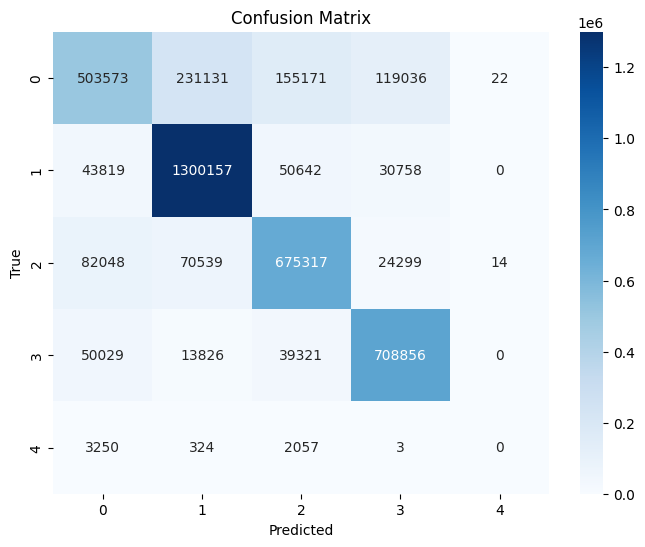

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, num_classes=num_classes):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=np.arange(num_classes))

    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_lbl, y_val_pred)

**Osservazione:** dalla confusion matrix si rileva il fatto che la classe 4 non venga praticamente classificata. Inoltre abbiamo errori nella classificazione delle altre classi, in particolar modo la classe 0 e le altre classi vengono molto confuse. La maggior parte delle classificazioni errate che si desidera correggere sono False Positives. Per fare ciò è possibile lavorare sia sulla struttura della rete, sia per esempio sulla scelta della loss function.

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241205_093042.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241205_093042.keras


In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step
Predictions shape: (10022, 64, 128)


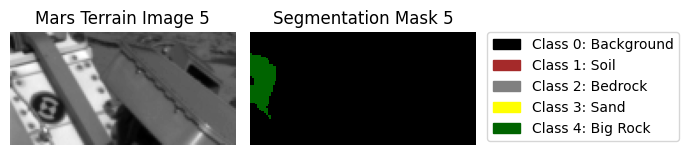

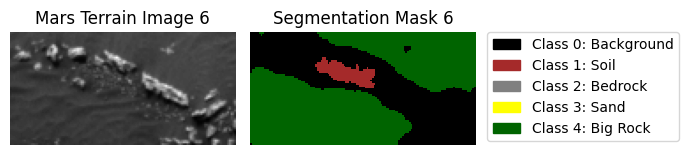

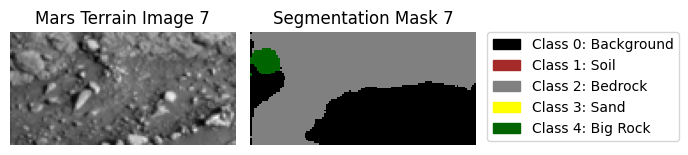

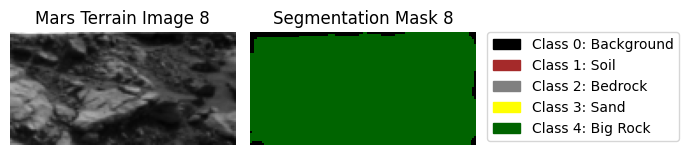

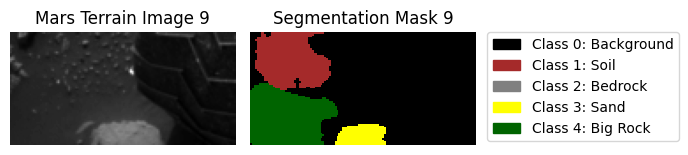

In [ ]:
# Visualize pred and image refere
display_images_with_masks(X_test, preds, start=5, end=10)

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)
print(f"Submission file saved to {submission_filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submission file saved to submission_241205_093042.csv
